# RNN과 LSTM

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

def f(txt,mapping):
    return [mapping[key] for key in txt]
    
soft = torch.nn.Softmax(dim=1)

## RNN과 LSTM 성능 비교 (data: abcabC)

### RNN

In [2]:
txt = list('abcabC')*100

txt_x = txt[:-1]
txt_y = txt[1:]

mapping = {'a':0, 'b':1, 'c':2, 'C':3}

x = torch.nn.functional.one_hot(torch.tensor(f(txt_x,mapping))).float()
y = torch.nn.functional.one_hot(torch.tensor(f(txt_y,mapping))).float()

x = x.to('cuda:0')
y = y.to('cuda:0')

In [16]:
torch.manual_seed(43052)

rnn = torch.nn.RNN(4,3).to('cuda:0')
lin = torch.nn.Linear(3,4).to('cuda:0')

loss_fn = torch.nn.CrossEntropyLoss()

optim = torch.optim.Adam(list(rnn.parameters())+ list(lin.parameters()))

In [17]:
for epoch in tqdm(range(12000)):
    _water = torch.zeros(1,3).to('cuda:0')
    hidden, ht = rnn(x,_water)
    output = lin(hidden)

    loss = loss_fn(output, y)

    loss.backward()

    optim.step()
    optim.zero_grad()

100%|██████████| 12000/12000 [00:53<00:00, 225.40it/s]


In [18]:
yhat = soft(output)

combined = torch.concat([hidden, yhat], axis = 1).data.to('cpu')

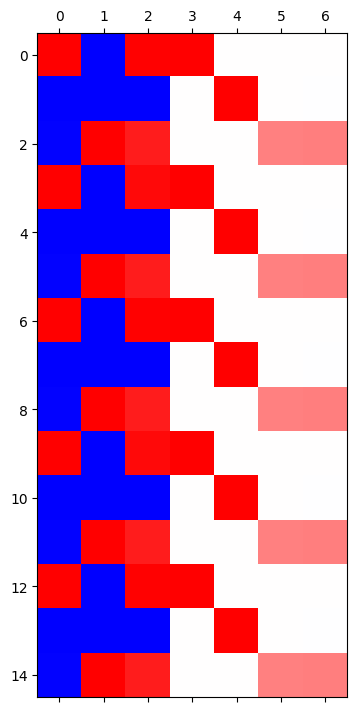

In [19]:
plt.matshow(combined[-15:], cmap = 'bwr')

- c와 C를 잘 구별하지 못하는 것을 알 수 있음
- 둘이 비슷한 확률로 출력됨
---
- 추가로 3000번 더 학습을 시켜보자!

In [20]:
for epoch in tqdm(range(3000)):
    _water = torch.zeros(1,3).to('cuda:0')
    hidden, ht = rnn(x,_water)
    output = lin(hidden)

    loss = loss_fn(output, y)

    loss.backward()

    optim.step()
    optim.zero_grad()

100%|██████████| 3000/3000 [00:13<00:00, 222.97it/s]


In [21]:
yhat = soft(output)

combined = torch.concat([hidden, yhat], axis = 1).data.to('cpu')

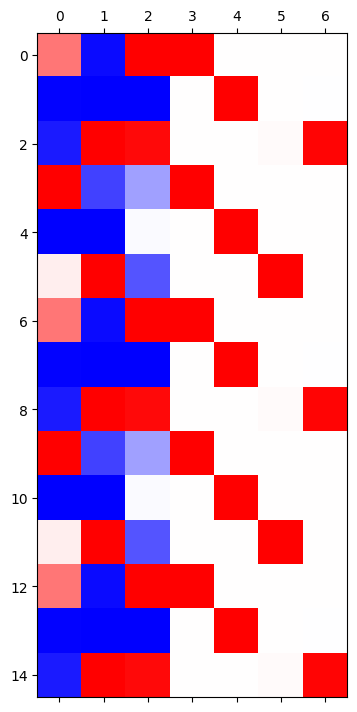

In [22]:
plt.matshow(combined[-15:], cmap = 'bwr')

- RNN은 15000번 정도 실행을 해야 c와 C를 구별할 수 있음 

### LSTM

In [23]:
torch.manual_seed(43052)

lstm = torch.nn.LSTM(4,3).to('cuda:0')
lin = torch.nn.Linear(3,4).to('cuda:0')

loss_fn = torch.nn.CrossEntropyLoss()

optim = torch.optim.Adam(list(lstm.parameters())+ list(lin.parameters()))

In [24]:
for epoch in tqdm(range(6000)):
    _water = torch.zeros(1,3).to('cuda:0')
    hidden, (ht, ct) = lstm(x,(_water,_water))
    output = lin(hidden)

    loss = loss_fn(output, y)

    loss.backward()

    optim.step()
    optim.zero_grad()

100%|██████████| 6000/6000 [00:26<00:00, 223.70it/s]


In [25]:
yhat = soft(output)

combined = torch.concat([hidden, yhat], axis = 1).data.to('cpu')

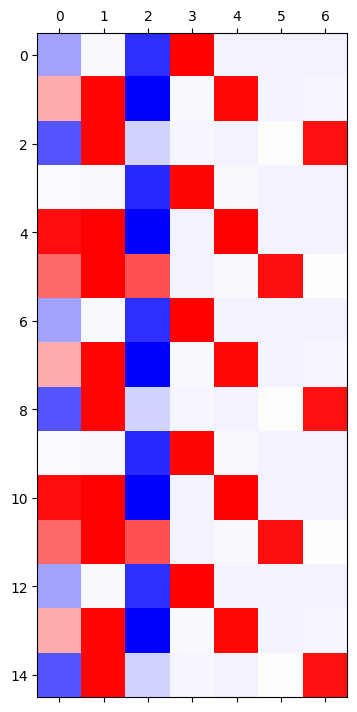

In [26]:
plt.matshow(combined[-15:], cmap = 'bwr')

- LSTM은 6000번의 학습으로도 c와 C를 구별할 수 있음

### 정리...

## LSTM의 구조

In [3]:
sig = torch.nn.Sigmoid()
tanh = torch.nn.Tanh()
soft = torch.nn.Softmax(dim=1)

In [4]:
txt = list('abaB') * 100

txt_x = txt[:-1]
txt_y = txt[1:]

mapping = {'a':0, 'b':1, 'B':2}

x = torch.nn.functional.one_hot(torch.tensor(f(txt_x,mapping))).float()
y = torch.nn.functional.one_hot(torch.tensor(f(txt_y,mapping))).float()

In [5]:
torch.manual_seed(43052)

lstm_cell = torch.nn.LSTMCell(3, 2)
lin = torch.nn.Linear(2,3)

loss_fn = torch.nn.CrossEntropyLoss()

optim = torch.optim.Adam(list(lstm_cell.parameters())+list(lin.parameters()))

In [6]:
lstm_cell.weight_ih.T.shape

torch.Size([3, 8])

In [32]:
T = len(x)

for epoch in range(1):
    ht = torch.zeros(1,2)
    ct = torch.zeros(1,2)
    loss = 0

    for t in range(T):
        xt,yt = x[[t]], y[[t]]
        ht, ct = lstm_cell(xt, (ht, ct))
        _ifgo = xt@lstm_cell.weight_ih.T + ht@lstm_cell.weight_hh.T + lstm_cell.bias_hh + lstm_cell.bias_ih

        # gate calculate
        input_gate = sig(_ifgo[:,0:2]) 
        forget_gate = sig(_ifgo[:,2:4]) 
        output_gate = sig(_ifgo[:,6:8])

        gt = tanh(_ifgo[:,4:6])

        ct = forget_gate*ct + input_gate*gt
        ht = output_gate*ct + tanh(ct) 

        ot = lin(ht)
#        loss = loss + loss_fn(ot, yt)
#    loss = loss/T

#    loss.backward()

#    optim.step()
#    optim.zero_grad()

$(x_t, h_{t-1}) \overset{lin}{\to} {a, b, c, d} \to [\sigma(a), \sigma(b), \tanh(c), \sigma(d)] = [i_t, f_t, g_t, o_t]$

`-` gate
- input_gate: $i_t$ `->` $g_t$의 값을 얼마나 통과시킬지를 0~1 사이의 값으로 보여줌
- forget_gate: $f_t$ `->` $C_{t-1}$의 값을 얼마나 통과시킬지를 0~1 사이의 값으로 보여줌
- output_gate: $o_t$ `->` $tanh(C_{t})$의 값을 얼마나 통과시킬지를 0~1 사이의 값으로 보여줌

`-` another value(?)
- gt: $g_t$ `->` $\sigma((W_{o1} X_t) + (W_{o2} h_{t-1}) + bias)$ `->` 현재와 과거의 값을 선형결합 *(w와 x또는 h를 곱함)* 후 tanh를 통과시켜 -1에서 1사이의 값으로 보여줌

- ct: $c_t$ `->` $forgetgate * C_{t-1} + inputgate * g_t$ `->` *는 아다마르 곱으로 요소별로 선택한 후 곱하는 연산으로 $g_t$연산과는 다름

- ht: $h_t$ `->` $tanh(C_t)*O_t$





In [30]:
ht, ct

(tensor([[-0.0406,  0.2505]], grad_fn=<MulBackward0>),
 tensor([[-0.0975,  0.7134]], grad_fn=<AddBackward0>))